In [1]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from visualization import HeatmapVisualizer, visualize_original
from torchvision.models import efficientnet_b0,EfficientNet_B0_Weights
import torch.nn as nn
import torch
from datasets import load_test_dataset
from methods import big_pipeline
my_font = fm.FontProperties(fname="fonts/SimHei.ttf")
mask_viz = HeatmapVisualizer(blur=7, normalization_type="signed_max")
device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
dataloader, data_min, data_max = load_test_dataset()

In [3]:
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.to(device)
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### BIG

BIG: 20.101632833480835 s


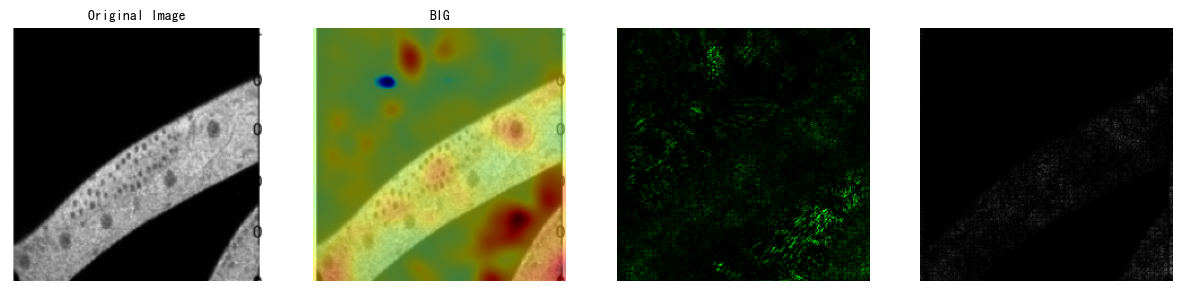

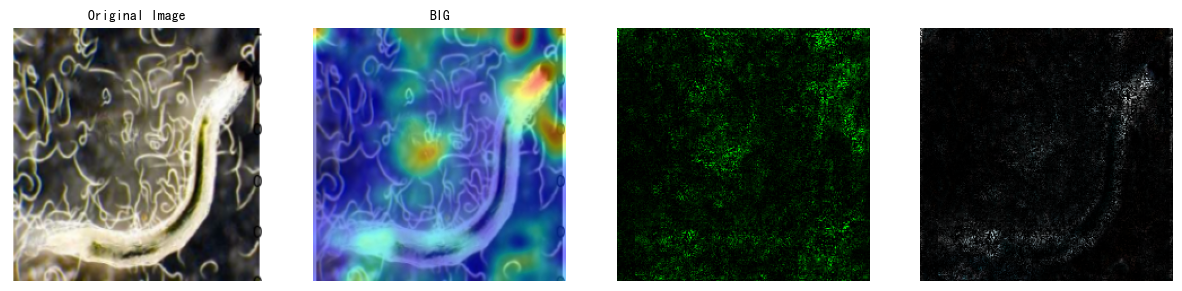

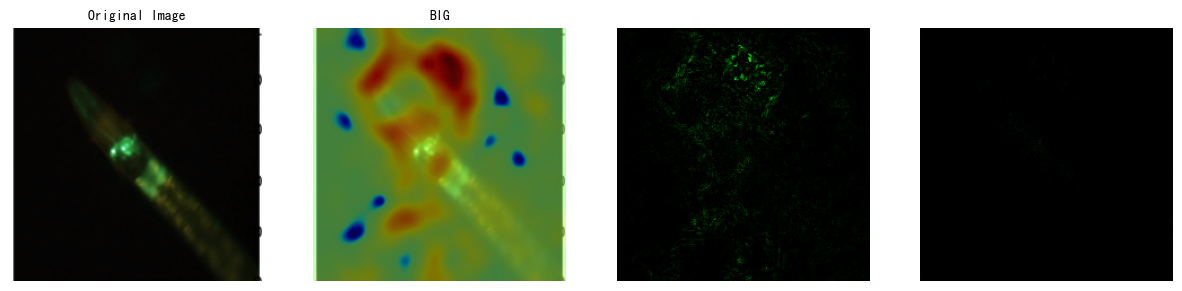

In [5]:
for data, target in dataloader:
    data = data.to(device)
    target = target.to(device)
    correct_index = torch.argmax(model(data), dim=-1) == target
    data = data[correct_index]
    target = target[correct_index]
    attribution_map,success = big_pipeline(model, data, target,data_min,data_max,class_num=1000)
    for i in range(len(data)):
        img = mask_viz._normalize(data[i:i+1].cpu().detach().numpy(), "01")
        img = img.squeeze().transpose(1, 2, 0) * 255
        img_integrated_gradient_overlay = visualize_original(
            attribution_map[i].transpose(1, 2, 0),
            img, clip_above_percentile=99, clip_below_percentile=0,
            overlay=True, mask_mode=True)
        img_integrated_gradient = visualize_original(attribution_map[i].transpose(
            1, 2, 0), img, clip_above_percentile=99, clip_below_percentile=0, overlay=False)
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))
        im_, mask = mask_viz(attribution_map[i:i+1], data[i:i+1].cpu().detach(
        ).numpy(), overlay_opacity=0.5, imshow=False, return_tiled=True)
        axes[0].axis('off')
        axes[0].set_title("Original Image", fontproperties=my_font)
        axes[0].imshow(img / 255)
        axes[0].axes.xaxis.set_ticks([])
        axes[0].axes.yaxis.set_visible(False)
        
        axes[1].axis('off')
        axes[1].set_title("BIG", fontproperties=my_font)
        axes[1].imshow(im_)
        axes[1].imshow(mask, alpha=0.5, cmap='jet')
        axes[1].axes.xaxis.set_ticks([])
        axes[1].axes.yaxis.set_visible(False)
        
        axes[2].axis('off')
        axes[2].imshow(img_integrated_gradient / 255)
        axes[2].axes.xaxis.set_ticks([])
        axes[2].axes.yaxis.set_visible(False)
        
        axes[3].axis('off')
        axes[3].imshow(img_integrated_gradient_overlay / 255)
        axes[3].axes.xaxis.set_ticks([])
        axes[3].axes.yaxis.set_visible(False)
        plt.show()
    break